In [1]:
# !export PYTHONPATH="${PYTHONPATH}:/Users/nickhoernle/edinburgh/dl2"

from symbolic import symbolic

import os
import sys
module_path = os.path.abspath(os.path.join('../../dl2/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from experiment.synthetic_experiments import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
import re

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
experiment = PartiallyKnownConstraintsSyntheticExperiment(size_of_train_set=1000, checkpoint_dir="../runs", learning_rate=.01)
train_loader, valid_loader, test_loader = experiment.get_loaders()

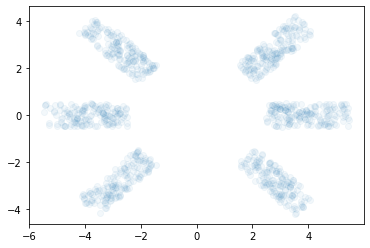

In [3]:
samps = []
for i, data in enumerate(train_loader):

    samples = data[0]
    labels = data[1]
    
    samps.append(samples)

plt.scatter(*torch.cat(samps, dim=0).numpy().T, alpha=.05)

Run the following commands from terminal first:

```
bash scripts/synthetic_experiments.txt
```

```
run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=False --size_of_train_set=100 --epochs=75 --seed=2 run
run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=False --size_of_train_set=250 --epochs=75 --seed=2 run
run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=False --size_of_train_set=500 --epochs=75 --seed=2 run
run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=False --size_of_train_set=1000 --epochs=75 --seed=2 run

run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=True --size_of_train_set=100 --epochs=75 --seed=2 run
run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=True --size_of_train_set=250 --epochs=75 --seed=2 run
run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=True --size_of_train_set=500 --epochs=75 --seed=2 run
run_synthetic_data_experiments.py synthetic_partial --learning_rate=1e-2 --baseline=True --size_of_train_set=1000 --epochs=75 --seed=2 run
```

# Compare the Loss Curves and the Constraint Accuracy

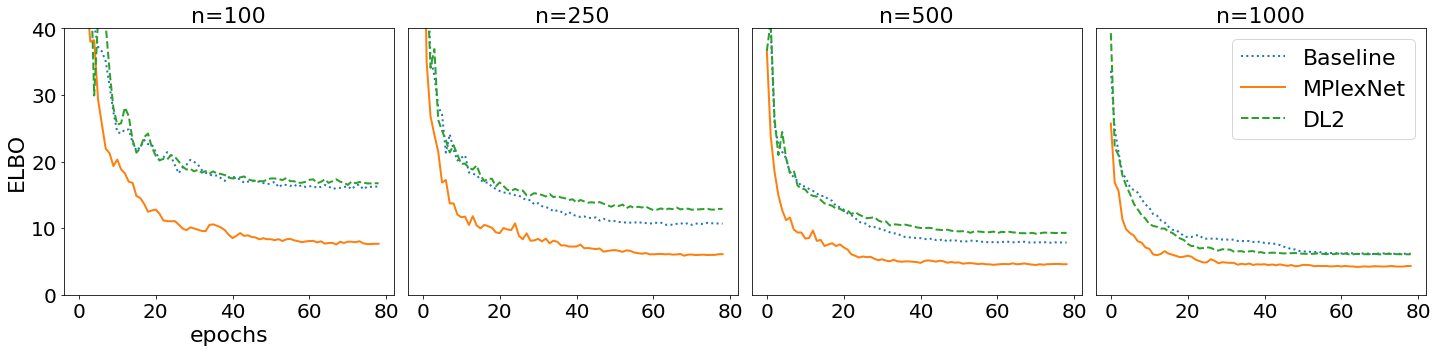

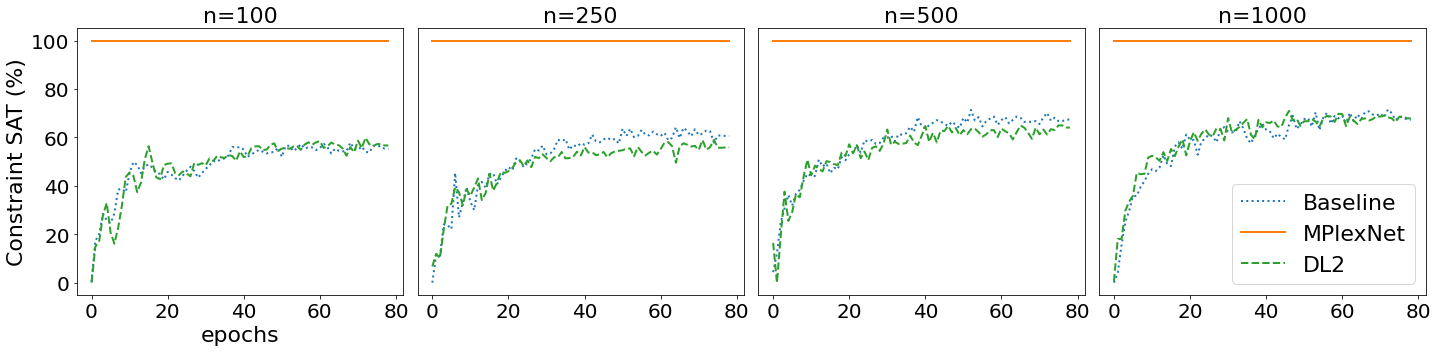

In [6]:
def parse_log_to_constraint_and_loss(infile):
    
    test_loss = []
    test_constraint = []
    
    for line in infile.readlines():
        if "Test" in line:
            [(loss, constraint)] = re.findall(r'.*Loss (\d+.\d+).*Constraint (\d+.\d+).*', line)
            test_loss.append(float(loss))
            test_constraint.append(float(constraint))
    return test_loss, test_constraint
           
loss_baseline, loss_sloss, loss_dl2 = [], [], []
constraint_baseline, constraint_sloss, constraint_dl2 = [], [], []

train_sizes = [100, 250, 500, 1000]
seeds = [2, 2, 2, 2]

for seed, dset_size in zip(seeds, train_sizes):
    with open(f"../runs/SyntheticPartial-0.01_{seed}_True_{dset_size}/logs/logs.txt", "r") as f:
        lb_, cb_ = parse_log_to_constraint_and_loss(f)
        loss_baseline.append(lb_)
        constraint_baseline.append(cb_)
        
    with open(f"../runs/SyntheticPartial-0.01_{seed}_False_{dset_size}/logs/logs.txt", "r") as f:
        ls_, cs_ = parse_log_to_constraint_and_loss(f)
        loss_sloss.append(ls_)
        constraint_sloss.append(cs_)
    
    with open(f"../runs/SyntheticDL2-0.01_{seed}_True_{dset_size}/logs/logs.txt", "r") as f:
        ls_, cs_ = parse_log_to_constraint_and_loss(f)
        loss_dl2.append(ls_)
        constraint_dl2.append(cs_)

fig, axes = plt.subplots(1, 4, figsize=(20,5))

# fig = plt.figure(figsize=(10, 5))
# ax = fig.gca()
c = ["C0", "C1", "C2", "C3"]

for i, v in enumerate(train_sizes):
    ax = axes[i]
    ax.plot(loss_baseline[i], label=f"Baseline", c=f"C0", ls=":", lw=2)
    ax.plot(loss_sloss[i], label=f"MPlexNet", c=f"C1", ls="-", lw=2)
    ax.plot(loss_dl2[i], label=f"DL2", c=f"C2", ls="--", lw=2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    ax.set_ylim([0, 40])
    ax.set_title(f"n={v}", fontsize=22)
    
    if i == 0:
        ax.set_ylabel("ELBO", fontsize=22)
        ax.set_xlabel("epochs", fontsize=22)
    else:
        ax.get_yaxis().set_ticks([])

ax.legend(loc="best", fontsize=22)

plt.tight_layout()
plt.savefig("images/synthetic_experiment_elbo.png", format='png')#, dpi=1200)
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(20,5))

for i, v in enumerate(train_sizes):
    ax = axes[i]
    ax.plot(constraint_baseline[i], label=f"Unaware VAE", c=f"C0", ls=":", lw=2)
    ax.plot(constraint_sloss[i], label=f"MPlexNet", c=f"C1", ls="-", lw=2)
    ax.plot(constraint_dl2[i], label=f"DL2-VAE", c=f"C2", ls="--", lw=2)
    ax.set_title(f"n={v}", fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    if i == 0:
        ax.set_ylabel("Constraint SAT (%)", fontsize=22)
        ax.set_xlabel("epochs", fontsize=22)
    else:
        ax.get_yaxis().set_ticks([])
        
ax.legend(loc="best", fontsize=22)

plt.tight_layout()
plt.savefig("images/synthetic_experiment_constraint_satisfaction.png", format='png')#, dpi=1200)
plt.show()

# Compare Samples from the Model

In [5]:
from IPython.display import Image

for use_baseline in [True, False]:
    for size_of_train_set in train_sizes:
        experiment = FullyKnownConstraintsSyntheticExperiment(
            size_of_train_set=size_of_train_set,
            checkpoint_dir="../runs",
            learning_rate=.01,
            baseline=use_baseline
        )
        model = experiment.load_model()
        experiment.plot_validation_reconstructions(-1, model, test_loader)
        print(experiment.figures_directory)

../runs/SyntheticFull-0.01_12_True_50/figures
../runs/SyntheticFull-0.01_12_True_100/figures
../runs/SyntheticFull-0.01_12_True_1000/figures
../runs/SyntheticFull-0.01_12_True_10000/figures
../runs/SyntheticFull-0.01_12_False_50/figures
../runs/SyntheticFull-0.01_12_False_100/figures
../runs/SyntheticFull-0.01_12_False_1000/figures
../runs/SyntheticFull-0.01_12_False_10000/figures


# n = 10

### Baseline

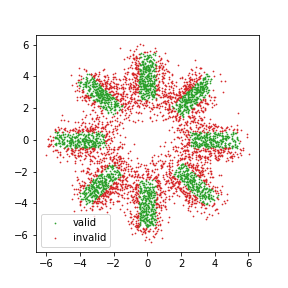

In [7]:
Image("../runs/SyntheticFull-0.01_12_True_50/figures/-1_reconstruction.png")

### MPlexNet

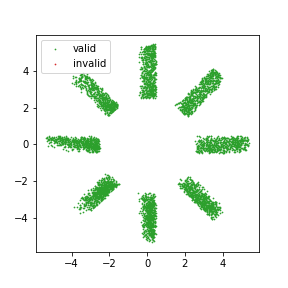

In [8]:
Image("../runs/SyntheticFull-0.01_12_False_50/figures/-1_reconstruction.png")

---

# n = 100
### Baseline

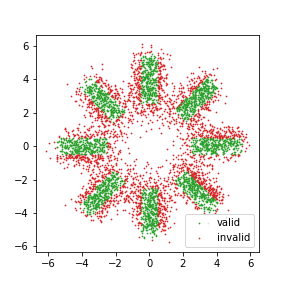

In [9]:
Image("../runs/SyntheticFull-0.01_12_True_100/figures/-1_reconstruction.png")

### MPlexNet

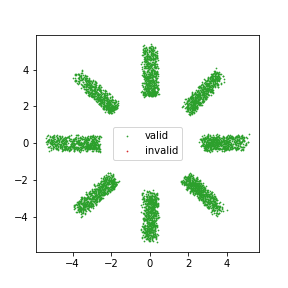

In [10]:
Image("../runs/SyntheticFull-0.01_12_False_100/figures/-1_reconstruction.png")

---

# n = 1000
### Baseline

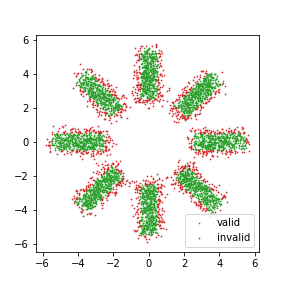

In [11]:
Image("../runs/SyntheticFull-0.01_12_True_1000/figures/-1_reconstruction.png")

### MPlexNet

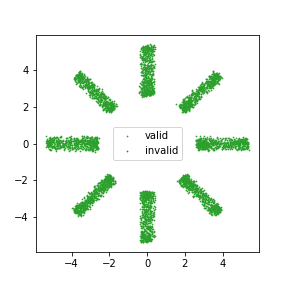

In [12]:
Image("../runs/SyntheticFull-0.01_12_False_1000/figures/-1_reconstruction.png")

---

# n = 10000
### Baseline

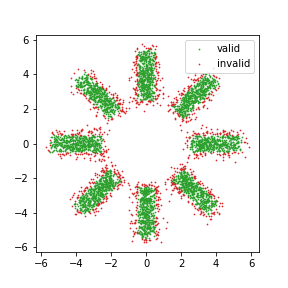

In [13]:
Image("../runs/SyntheticFull-0.01_12_True_10000/figures/-1_reconstruction.png")

### MPlexNet

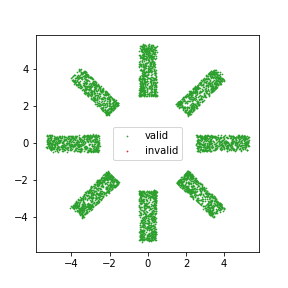

In [14]:
Image("../runs/SyntheticFull-0.01_12_False_10000/figures/-1_reconstruction.png")

---